> This notebook is intended to be used in Google Colab

In [357]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [358]:
directory = 'letters/'

# Parameters
img_height, img_width = 80, 60
batch_size = 32
epochs = 10
num_augmented_images = 500

images = []
labels = []

for filename in os.listdir(directory):
    if filename.endswith('.png'):
        img_path = os.path.join(directory, filename)
        label = filename.split('.')[0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        img = cv2.resize(img, (img_width, img_height))
        images.append(img)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

images = np.expand_dims(images, axis=-1)


R
(80, 60, 1)


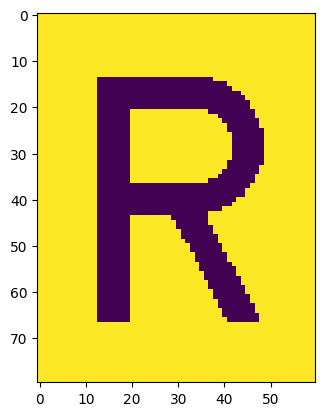

In [359]:
print(labels[0])
print(images[0].shape)
plt.imshow(images[0])

In [360]:
def label_to_index(label):
    if 'A' <= label <= 'Z':
        return ord(label) - ord('A')
    elif '0' <= label <= '9':
        return ord(label) - ord('0') + 26
    else:
        raise ValueError(f"Unsupported label: {label}")

labels = tf.keras.utils.to_categorical([label_to_index(label) for label in labels], num_classes=36)

def custom_preprocessing(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    rounded_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)
    img_array = rounded_image.reshape(rounded_image.shape + (1,))
    return img_array

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing
)

augmented_images = []
augmented_labels = []

for i, image in enumerate(images):
    img_array = image.reshape((1,) + image.shape)
    label = labels[i]

    j = 0
    for batch in datagen.flow(img_array, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        j += 1
        if j >= num_augmented_images:
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

augmented_images = augmented_images / 255.0

x_train, x_val, y_train, y_val = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

In [361]:
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [362]:
import random

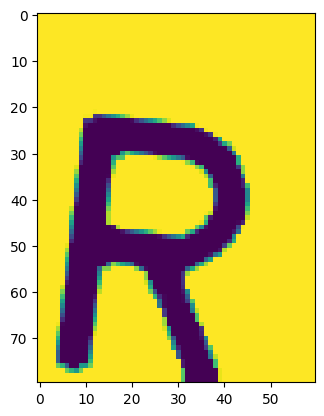

In [363]:
plt.imshow(x_train[random.randint(0, 150)])

In [364]:
# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(36, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)



Epoch 1/10
438/438 [==============================] - 90s 204ms/step - loss: 0.0597 - accuracy: 0.6478 - val_loss: 0.0130 - val_accuracy: 0.9589
Epoch 2/10
438/438 [==============================] - 89s 203ms/step - loss: 0.0069 - accuracy: 0.9824 - val_loss: 0.0039 - val_accuracy: 0.9917
Epoch 3/10
438/438 [==============================] - 93s 213ms/step - loss: 0.0024 - accuracy: 0.9949 - val_loss: 0.0046 - val_accuracy: 0.9914
Epoch 4/10
438/438 [==============================] - 93s 211ms/step - loss: 0.0012 - accuracy: 0.9979 - val_loss: 0.0019 - val_accuracy: 0.9963
Epoch 5/10
438/438 [==============================] - 90s 206ms/step - loss: 0.0013 - accuracy: 0.9987 - val_loss: 0.0022 - val_accuracy: 0.9937
Epoch 6/10
438/438 [==============================] - 95s 216ms/step - loss: 0.0015 - accuracy: 0.9989 - val_loss: 0.0024 - val_accuracy: 0.9971
Epoch 7/10
438/438 [==============================] - 91s 208ms/step - loss: 5.0929e-04 - accuracy: 0.9998 - val_loss: 8.3575e-04 

In [365]:
model.save('ocr.keras')